In [27]:
# ─────────────────────────────────────────────
# Zelle 1  |  Imports & Daten laden
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

urls = {
    "kiwo"  : "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv",
    "umsatz": "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv",
    "wetter": "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv",
}

kiwo, umsatz, wetter = (pd.read_csv(urls[k]) for k in ("kiwo", "umsatz", "wetter"))

for df in (kiwo, umsatz, wetter):
    df["Datum"] = pd.to_datetime(df["Datum"])

In [28]:
# ─────────────────────────────────────────────
# Zelle 2  |  Mergen  (umsatz = Master)
# ─────────────────────────────────────────────

# Feiertags-Datensatz laden
feiertage = pd.read_csv('/workspaces/bakery_sales_prediction/5_Datasets/DE-Feiertage_2020_bis_2035.csv', 
                       sep=';', 
                       encoding='utf-8')

# Datum in feiertage konvertieren (vom deutschen Format DD.MM.YYYY)
feiertage['Datum'] = pd.to_datetime(feiertage['Datum'], format='%d.%m.%Y')

# Binary Flag für Feiertag erstellen
feiertage['ist_feiertag'] = 1

# Hauptmerge wie bisher
df = (
    umsatz
    .merge(kiwo[["Datum", "KielerWoche"]], on="Datum", how="left")  # left statt inner
    .merge(wetter, on="Datum", how="left")
    .merge(feiertage[["Datum", "ist_feiertag", "Feiertag"]], 
           on="Datum", how="left")  # Feiertage hinzufügen
)

# Nachbearbeitung
df["KielerWoche"] = df["KielerWoche"].fillna(0).astype(int)
df["ist_feiertag"] = df["ist_feiertag"].fillna(0).astype(int)  # 0 für Nicht-Feiertage

# Optional: Zusätzliche Features erstellen
# Feiertag am Vortag oder Folgetag (Brückentage)
df = df.sort_values('Datum').reset_index(drop=True)
df['feiertag_vortag'] = df['ist_feiertag'].shift(1).fillna(0).astype(int)
df['feiertag_folgetag'] = df['ist_feiertag'].shift(-1).fillna(0).astype(int)

print("Monatsverteilung:", df["Datum"].dt.month.value_counts().sort_index(), sep="\n")
print("\nFeiertage im Datensatz:", df['ist_feiertag'].sum())
# Beispiel: Zeige einige Feiertage im Datensatz
print("\nBeispiel Feiertage im Datensatz:")
print(df[df['ist_feiertag'] == 1][['Datum', 'Feiertag', 'Umsatz']].head(10))

Monatsverteilung:
Datum
1     756
2     705
3     759
4     731
5     736
6     745
7     904
8     756
9     747
10    777
11    886
12    832
Name: count, dtype: int64

Feiertage im Datensatz: 201

Beispiel Feiertage im Datensatz:
         Datum                   Feiertag      Umsatz
462 2013-10-03  Tag der deutschen Einheit  440.898116
463 2013-10-03  Tag der deutschen Einheit   75.233730
464 2013-10-03  Tag der deutschen Einheit  148.994653
465 2013-10-03  Tag der deutschen Einheit  192.293311
466 2013-10-03  Tag der deutschen Einheit  592.567211
928 2013-12-24                Heiligabend  531.778120
929 2013-12-24                Heiligabend  131.060158
930 2013-12-24                Heiligabend  220.330670
931 2013-12-24                Heiligabend   61.368782
932 2013-12-24                Heiligabend  251.566251


# ─────────────────────────────────────────────
# Zelle 2  |  Mergen  (umsatz = Master)
# ─────────────────────────────────────────────
df = (
    umsatz
    .merge(kiwo[["Datum", "KielerWoche"]], on="Datum", how="left")  # left statt inner
    .merge(wetter, on="Datum", how="left")    
    .merge(feiertage[["Datum", "ist_feiertag", "Feiertag", "feiertag_kategorie"]], 
           on="Datum", how="left")  # Feiertage hinzufügen
    
)
df["KielerWoche"] = df["KielerWoche"].fillna(0).astype(int)

print("Monatsverteilung:", df["Datum"].dt.month.value_counts().sort_index(), sep="\n")

In [29]:
# ─────────────────────────────────────────────
# Zelle 3  |  Erste Reinigung & Winsorisierung
# ─────────────────────────────────────────────
# Duplikate
df = df.drop_duplicates()

# Spaltennamen säubern
df.columns = df.columns.str.strip()

# Winsorisieren von Umsatz
p5, p95 = np.percentile(df["Umsatz"], [5, 95])
df["Umsatz"] = df["Umsatz"].clip(lower=p5, upper=p95)

In [30]:
# ─────────────────────────────────────────────
# Zelle 4  |  Typkonvertierungen & Feature Engineering
# ─────────────────────────────────────────────
# Warengruppe benennen
mapping = {1:"Brot", 2:"Brötchen", 3:"Croissant", 4:"Konditorei", 5:"Kuchen", 6:"Saisonbrot"}
df["Warengruppe"] = df["Warengruppe"].map(mapping).astype("category")

# Zeitliche Features
df["Wochentag"]  = df["Datum"].dt.day_name().astype("category")
df["Monat"]      = df["Datum"].dt.month.astype("category")
df["Jahr"]       = df["Datum"].dt.year.astype("category")

def season(month):
    return ("Winter","Frühling","Sommer","Herbst")[(month%12)//3]
df["Jahreszeit"] = pd.Categorical(df["Datum"].dt.month.map(season),
                                  categories=["Frühling","Sommer","Herbst","Winter"],
                                  ordered=True)

# Wettercode-Fehlindikator
df["Wettercode_fehlt"] = df["Wettercode"].isna().astype(int)

In [31]:
# ─────────────────────────────────────────────
# Zelle 5  |  Deskriptive Statistiken & Korrelation
# ─────────────────────────────────────────────
print("DESKRIPTIV:")
display(df.describe(include="all"))

print("\nKORRELATION:")
nums = df.select_dtypes("number")
display(nums.corr())

DESKRIPTIV:


,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,ist_feiertag,Feiertag,feiertag_vortag,feiertag_folgetag,Wochentag,Monat,Jahr,Jahreszeit,Wettercode_fehlt
count,9.334000e+03,9334,9334,9334.000000,9334.000000,9264.000000,9318.000000,9318.000000,7009.000000,9334.000000,201,9334.000000,9334.000000,9334,9334.0,9334.0,9334,9334.000000
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,7,12.0,6.0,4,NaN
top,NaN,NaN,Brot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heiligabend,NaN,NaN,Tuesday,7.0,2015.0,Herbst,NaN
freq,NaN,NaN,1819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,NaN,NaN,1345,904.0,1848.0,2410,NaN
mean,1.559311e+06,2016-01-13 23:56:27.100921344,NaN,201.420387,0.023891,4.720747,12.028483,10.974780,36.900128,0.021534,NaN,0.021534,0.021534,NaN,NaN,NaN,NaN,0.249089
min,1.307011e+06,2013-07-01 00:00:00,NaN,59.208548,0.000000,0.000000,-8.475000,3.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
25%,1.410123e+06,2014-10-12 00:00:00,NaN,96.897441,0.000000,3.000000,6.237500,8.000000,10.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
50%,1.601102e+06,2016-01-10 00:00:00,NaN,161.900831,0.000000,6.000000,11.625000,10.000000,28.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
75%,1.704223e+06,2017-04-22 00:00:00,NaN,280.644663,0.000000,7.000000,17.962500,13.000000,61.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
max,1.807315e+06,2018-07-31 00:00:00,NaN,494.258576,1.000000,8.000000,31.437500,35.000000,95.000000,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000



KORRELATION:


,id,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,ist_feiertag,feiertag_vortag,feiertag_folgetag,Wettercode_fehlt
id,1.000000,-0.079158,0.048994,-0.010526,-0.069656,0.007566,-0.095554,0.008093,0.010259,0.008084,-0.188095
Umsatz,-0.079158,1.000000,0.055967,-0.091876,0.224843,0.015614,-0.017002,0.060615,0.047093,0.057654,0.078565
KielerWoche,0.048994,0.055967,1.000000,0.011251,0.138339,0.020500,0.066911,-0.023209,-0.023209,-0.023209,0.003979
Bewoelkung,-0.010526,-0.091876,0.011251,1.000000,-0.391635,0.041809,0.525547,-0.026003,-0.026707,-0.021523,-0.390809
Temperatur,-0.069656,0.224843,0.138339,-0.391635,1.000000,0.003734,-0.086582,-0.008403,-0.007263,-0.011239,0.313660
Windgeschwindigkeit,0.007566,0.015614,0.020500,0.041809,0.003734,1.000000,0.119232,0.040598,0.037645,0.038452,-0.084334
Wettercode,-0.095554,-0.017002,0.066911,0.525547,-0.086582,0.119232,1.000000,0.044727,0.034751,0.031821,NaN
ist_feiertag,0.008093,0.060615,-0.023209,-0.026003,-0.008403,0.040598,0.044727,1.000000,0.842377,0.842377,-0.001821
feiertag_vortag,0.010259,0.047093,-0.023209,-0.026707,-0.007263,0.037645,0.034751,0.842377,1.000000,0.684754,0.005005
feiertag_folgetag,0.008084,0.057654,-0.023209,-0.021523,-0.011239,0.038452,0.031821,0.842377,0.684754,1.000000,-0.001821


/tmp/ipykernel_6181/1812644890.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Warengruppe", y="Umsatz", data=df,


/tmp/ipykernel_6181/1812644890.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Bewoelkung", y="Umsatz", data=df,


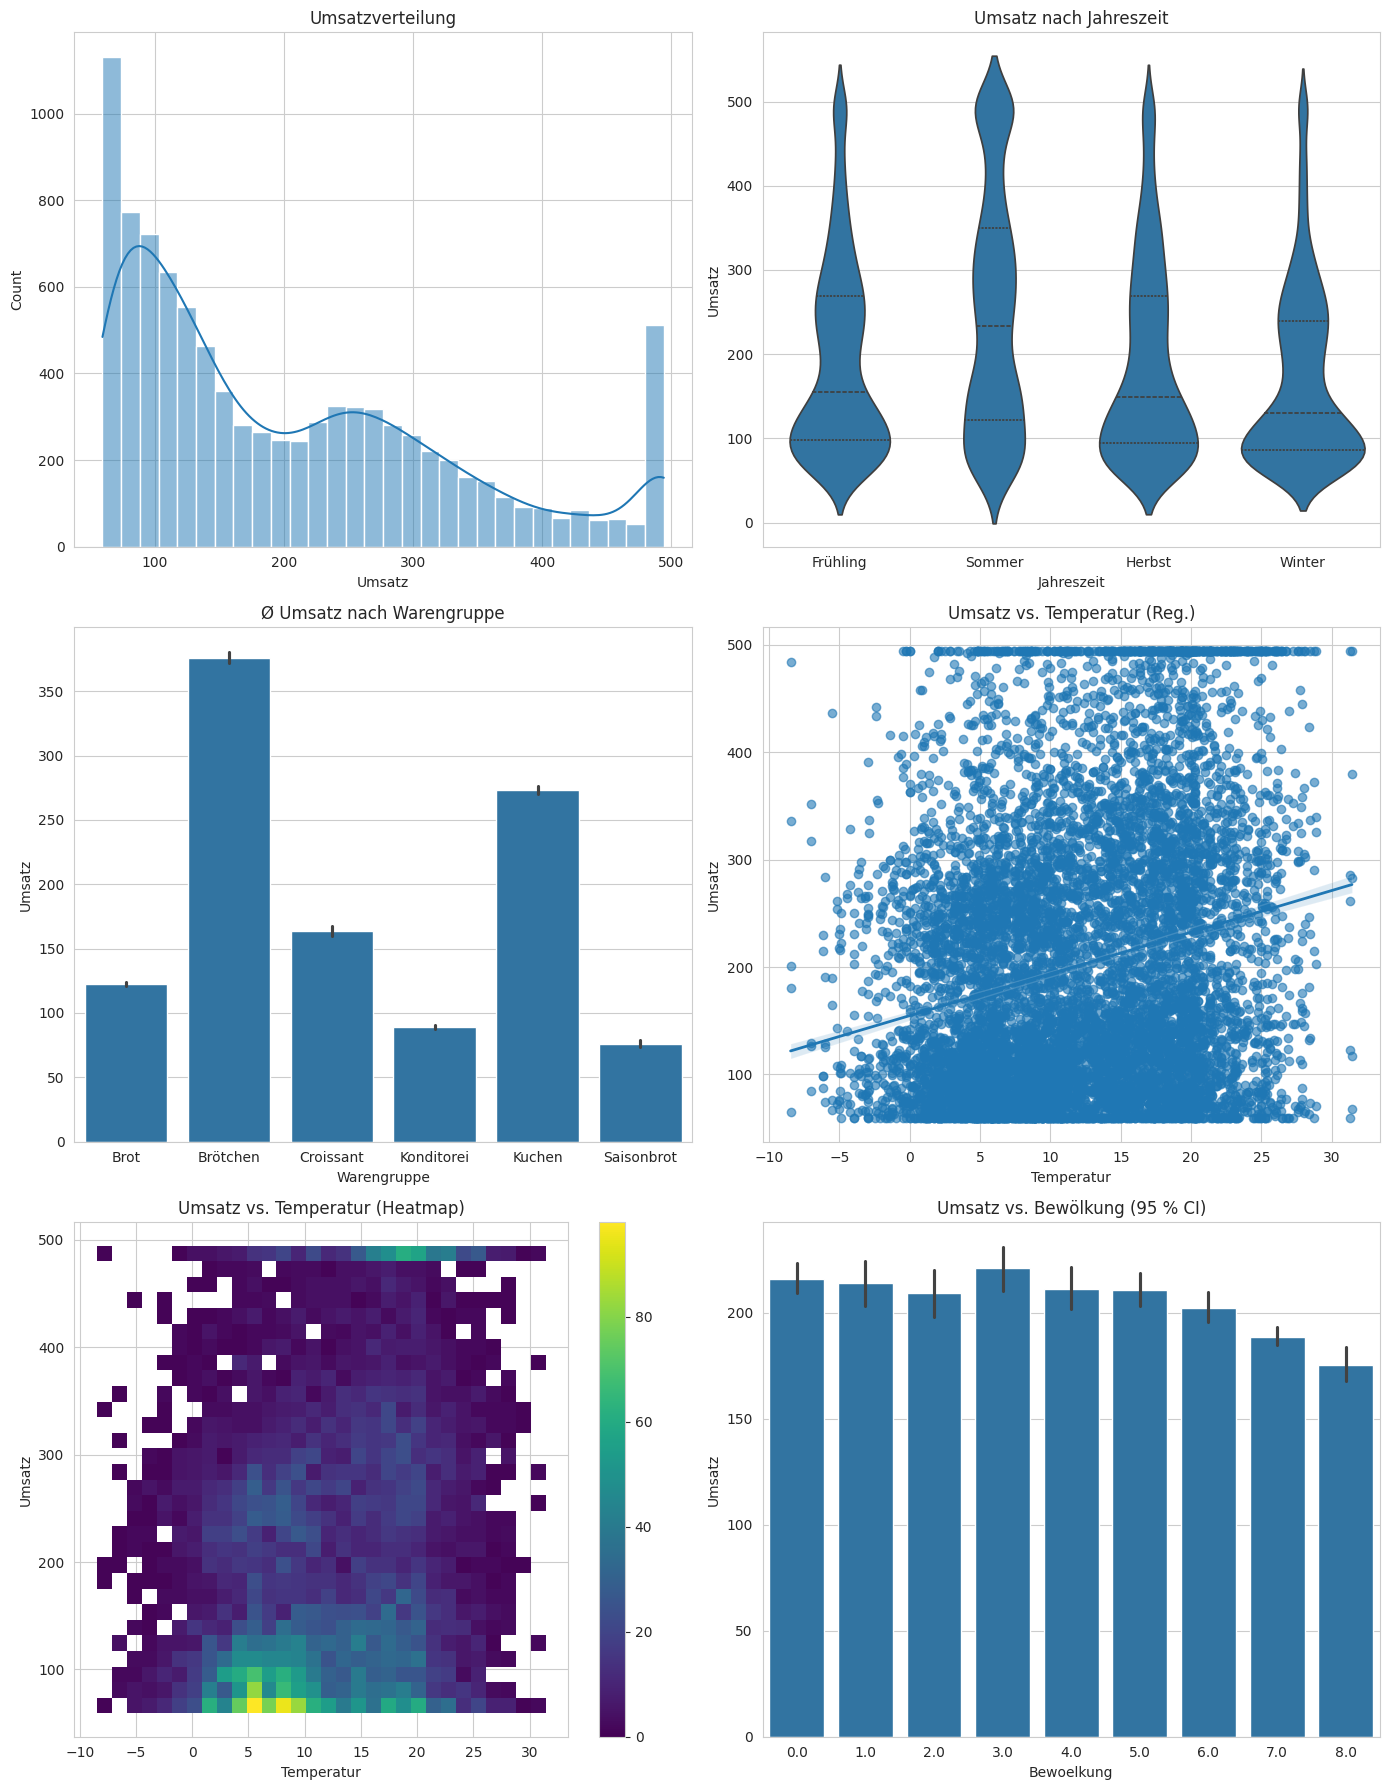

In [32]:
# ─────────────────────────────────────────────
# Zelle 6  |  Plots (überarbeitet)
# ─────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(14, 18)); axes = axes.flatten()

sns.histplot(df["Umsatz"], kde=True, bins=30, ax=axes[0])
axes[0].set_title("Umsatzverteilung")

sns.violinplot(x="Jahreszeit", y="Umsatz", data=df,
               order=["Frühling","Sommer","Herbst","Winter"],
               inner="quartile", ax=axes[1])
axes[1].set_title("Umsatz nach Jahreszeit")

sns.barplot(x="Warengruppe", y="Umsatz", data=df,
            order=["Brot","Brötchen","Croissant","Konditorei","Kuchen","Saisonbrot"],
            estimator=np.mean, ci=95, ax=axes[2])
axes[2].set_title("Ø Umsatz nach Warengruppe")

sns.regplot(x="Temperatur", y="Umsatz", data=df,
            scatter_kws={"alpha":0.6}, line_kws={"lw":2}, ax=axes[3])
axes[3].set_title("Umsatz vs. Temperatur (Reg.)")

sns.histplot(data=df, x="Temperatur", y="Umsatz",
             bins=30, cbar=True, cmap="viridis", ax=axes[4])
axes[4].set_title("Umsatz vs. Temperatur (Heatmap)")

sns.barplot(x="Bewoelkung", y="Umsatz", data=df,
            estimator=np.mean, ci=95, ax=axes[5])
axes[5].set_title("Umsatz vs. Bewölkung (95 % CI)")

plt.tight_layout(); plt.show()

In [34]:
df.to_csv('final_dataset.csv', index=False)